**Packages Explanation**


----

* **xarray**: xarray is a powerful package that simplifies working with labeled multi-dimensional arrays. It provides efficient data structures and functions for handling and analyzing multidimensional datasets, such as NetCDF files commonly used in earth sciences.

* **pickle**: pickle is a module in Python that enables the serialization and deserialization of Python objects. It is used to store and retrieve fixed points from two buffers in our case, which are saved as serialized objects.

* **datetime**: The datetime module supplies classes for working with dates and times in Python. It provides functionalities to create, manipulate, and format dates and times.

* **pandas**: pandas is a popular data manipulation and analysis library. It provides high-performance data structures, such as DataFrame, for handling structured data. We use it for various data processing and manipulation tasks.

* **scipy.spatial.cKDTree**: The cKDTree class from the scipy.spatial module provides an efficient implementation of a k-dimensional tree. It allows fast nearest neighbor search and is used to find the nearest points in our code.

* **numpy**: numpy is a fundamental package for scientific computing in Python. It provides efficient arrays, mathematical functions, and linear algebra operations. It is widely used for numerical computations and forms the foundation for many other scientific libraries.

* **cartopy.crs**: cartopy.crs module provides cartographic coordinate reference systems (CRS) for creating maps and handling geographic data. It is used to specify the CRS for plotting maps and spatial data.

* **matplotlib.pyplot**: matplotlib.pyplot is a plotting library that provides a MATLAB-like interface for creating visualizations in Python. It is commonly used for creating various types of plots and charts.

* **shapely.geometry**: The shapely.geometry module from the shapely library provides geometric objects and operations for working with spatial data. It is used to create and manipulate polygons, lines, and points in our code.

* **geopandas**: geopandas is a library built on top of pandas and shapely that extends their functionalities to handle geospatial data. It provides data structures and tools for working with spatial datasets, such as reading, writing, and analyzing geospatial data.

* **matplotlib.colors.LinearSegmentedColormap**: LinearSegmentedColormap is a class in the matplotlib.colors module that defines a color map by specifying a sequence of colors and positions. It is used to create a custom color map for visualizing sea surface temperature (SST) data in our code.

* **seaborn**: seaborn is a high-level statistical data visualization library built on top of matplotlib. It provides a more visually appealing and intuitive interface for creating statistical graphics and plots.

In [1]:
import xarray as xr
import pickle
import datetime
import pandas as pd
from scipy.spatial import cKDTree
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

This code is used to find and compare sea surface temperatures (SST) at various geographic points. There are two primary functions: **find_nearest_sst** and **get_sst_difference**.

The **find_nearest_sst** function uses a spatial **tree** data structure to quickly find the SST at a given point (identified by its longitude and latitude). It queries the spatial tree for the nearest neighbor to the input point, then uses the index of that neighbor to fetch the corresponding SST from the dataset.

The **get_sst_difference** function calculates the differences in SST between two sets of points. It takes in two sets of points and the dataset, then calls find_nearest_sst on each point in the two sets. It subtracts the SST values of each pair of points, collecting these differences in a list which it then returns.

In [2]:
# Define latitude and longitude range as slices
lats = slice(35, -5)
lons = slice(45, 90)

# This function finds the nearest sea surface temperature (SST) for a given point using a spatial tree.
def find_nearest_sst(point, tree, ds):
    # Get coordinates from the point
    lon, lat = point.x, point.y
    # Query the tree to find the nearest point and get its index
    _, idx = tree.query(np.array([lon, lat]), k=1)
    # Use the index to get the corresponding SST from the data
    nearest_sst = ds['sea_surface_temperature'].values.ravel()[idx]
    # Return the SST
    return nearest_sst

# This function calculates the difference in SST between two sets of points
def get_sst_difference(ds, points1, points2, tree):
    # Initialize an empty list to hold the SST differences
    sst_diff = []
    # Iterate over pairs of points
    for point1, point2 in zip(points1, points2):
        # Find the SST for each point
        sst1 = find_nearest_sst(point1, tree, ds)
        sst2 = find_nearest_sst(point2, tree, ds)
        # Calculate the difference and append it to the list
        sst_diff.append(sst1 - sst2)
    return sst_diff

This part of the code is loading two sets of data from pickle files: **sampled_points_50km** and **nearest_points** that we have previously defined in the last notebook.

In [3]:
with open('/home/jovyan/shared/jiarui-notebooks/sampled_points_50km.pickle', 'rb') as handle:
    sampled_points_50km = pickle.load(handle)

with open('/home/jovyan/shared/jiarui-notebooks/nearest_points.pickle', 'rb') as handle1:
    nearest_points = pickle.load(handle1)

# SST Diff Visualization
Here We select **July's SST data from 1988** for visualization.

In [4]:
temp_file = xr.open_dataset('/home/jovyan/shared/data_sst/198807_sea_surface_temperature.nc')
temp_file

<xarray.Dataset>
Dimensions:                  (lon: 1440, lat: 721, time0: 744)
Coordinates:
  * lon                      (lon) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * lat                      (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * time0                    (time0) datetime64[ns] 1988-07-01 ... 1988-07-31...
Data variables:
    sea_surface_temperature  (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

**This chunk handles data visualization of the sea surface temperatures (SSTs) and their differences.**

First, the code creates a **Plate Carree coordinate reference system** (CRS). It loads a low-resolution Natural Earth dataset for global coastline data, defines a bounding box based on previously defined latitude and longitude ranges, and clips the coastline data according to this bounding box.

Next, it creates a **k-D tree** from the coordinates of the temperature dataset and calculates SST differences between sampled points and nearest points using the defined get_sst_difference function. It finds indices of sampled points where the SST difference **exceeds a predefined threshold**.

Finally, the code generates a plot. For each pair of points where the SST difference exceeds the threshold, it plots a red line connecting the two points. It also plots the sampled points in blue, the nearest points in red, and the clipped coastline in black. The x and y limits of the plot are set to match the bounding box.

/tmp/ipykernel_46/563075401.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  coastline = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


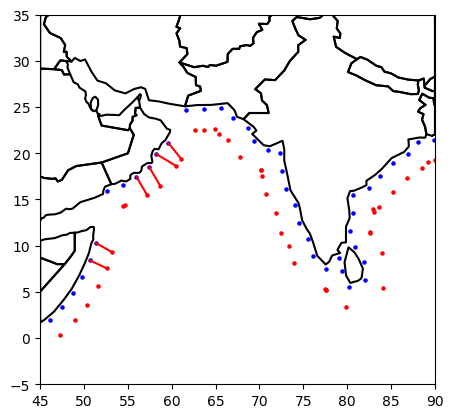

In [5]:
# Create a Plate Carree coordinate reference system (CRS)
crs = ccrs.PlateCarree()

# Read the low-resolution Natural Earth dataset which contains global coastline data
coastline = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define a bounding box using the previously defined latitude and longitude slices, convert it to a GeoDataFrame
bbox = Polygon([(lons.start, lats.start), (lons.start, lats.stop), (lons.stop, lats.stop), (lons.stop, lats.start)])
bbox_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bbox), columns=['geometry'])
# Set the CRS for the GeoDataFrame
bbox_gdf.set_crs('EPSG:4326', inplace=True)

# Clip the coastline data using the bounding box
coastline_clipped = gpd.clip(coastline, bbox_gdf)

# Define a threshold value for SST difference
threshold = -1

# Create a coordinate meshgrid using the temperature file's lat and lon values
lon_temp, lat_temp = np.meshgrid(temp_file['lon'].values, temp_file['lat'].values)
# Create a k-D tree from the coordinate meshgrid
tree = cKDTree(np.column_stack((lon_temp.ravel(), lat_temp.ravel())))

# Calculate SST differences using the defined function
sst_diff = get_sst_difference(temp_file, sampled_points_50km.geometry, nearest_points.geometry, tree)
# Find indices of the sampled points where SST difference is less than the defined threshold
exceeded_threshold_indices = [i for i, diff in zip(sampled_points_50km.index, sst_diff) if diff < threshold]

# Initialize a matplotlib figure and axes
fig, ax = plt.subplots()
# Plot a red line for each pair of points where SST difference exceeded the threshold
for i in exceeded_threshold_indices:
    point1 = sampled_points_50km.geometry.loc[i]
    point2 = nearest_points.geometry.loc[i]
    line = LineString([point1, point2])
    xs, ys = line.xy
    ax.plot(xs, ys, color='red')

# Plot the sampled points in blue and the nearest points in red
sampled_points_50km.plot(ax=ax, color='blue', markersize=5)
nearest_points.plot(ax=ax, color='red', markersize=5)
# Plot the clipped coastline in black
coastline_clipped.boundary.plot(ax=ax, color='black')
# Set the x and y limits to match the bounding box
plt.xlim([45, 90])
plt.ylim([-5, 35])
# Show the plot
plt.show()

Here is a more detailed visualization with the day 0's SST data from July, 1988. The color map used here is `rainbow_r`, and the level ranges from 290 to 310. You can also visit [here](https://coastwatch.pfeg.noaa.gov/erddap/griddap/ncdcOisst21Agg.graph?sst%5B(2011-01-01T12:00:00Z)%5D%5B(0.0)%5D%5B(17.625):(22.625)%5D%5B(67.125):(72.125)%5D&.draw=surface&.vars=longitude%7Clatitude%7Csst&.colorBar=%7C%7C%7C20%7C32%7C&.bgColor=0xffccccff) for more convenient visualizations.

In [10]:
def plot_sst(ds, sampled_points, nearest_points, threshold, tree):
    # Get SST differences
    sst_diff = get_sst_difference(ds, sampled_points.geometry, nearest_points.geometry, tree)
    exceeded_threshold_indices = [i for i, diff in zip(sampled_points.index, sst_diff) if diff < threshold]

    fig, ax = plt.subplots()

    # Define a color bar
    cmap = LinearSegmentedColormap.from_list("erddap_rainbow",
        [(0, 'purple'),
         (0.125, 'blue'),
         (0.375, 'cyan'),
         (0.625, 'yellow'),
         (0.875, 'orange'),
         (1, 'red')])

    # Using cmap=jet to simulate the default 'rainbow' color map of ERDDAP
    plt.contourf(ds['lon'].values, ds['lat'].values, ds['sea_surface_temperature'].values[0, :, :], cmap='rainbow_r', levels=np.arange(290, 310.5, 0.5))
    cbar = plt.colorbar(label='SST')

    for i in exceeded_threshold_indices:
        point1 = sampled_points.geometry.loc[i]
        point2 = nearest_points.geometry.loc[i]
        line = LineString([point1, point2])
        xs, ys = line.xy
        ax.plot(xs, ys, color='red')

    # Plot sampled points and nearest points
    sampled_points.plot(ax=ax, color='blue', markersize=5)
    nearest_points.plot(ax=ax, color='red', markersize=5)

    # Plot coastline (you need to ensure that 'coastline_clipped' is defined and accessible in this scope)
    coastline_clipped.boundary.plot(ax=ax, color='black')

    # Set plot limits
    plt.xlim([45, 90])
    plt.ylim([-5, 35])

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Sea Surface Temperature and Upwelling Locations')
    plt.show()

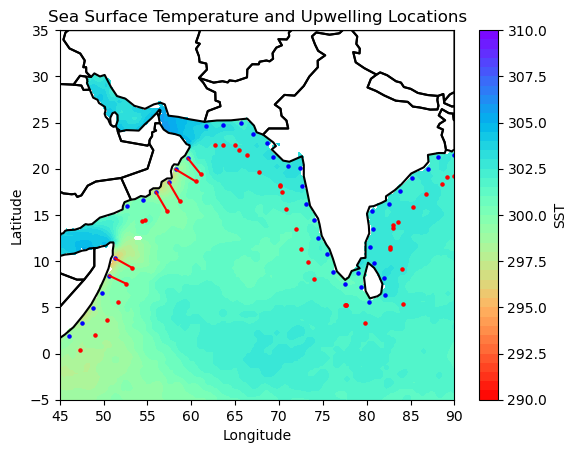

In [13]:
day0_data = temp_file.sel(time0='1988-07-01')
plot_sst(day0_data, sampled_points_50km, nearest_points, -1, tree)

# Entire SST Differences Generation

This code reads in a series of .nc files from a directory, each of which contains **sea surface temperature** (SST) data for a particular month. It sorts the files by month, then for each file, it reads in the data, selects the relevant time range and geographical area, and calculates the **difference in SST** between each point and its nearest neighbor. These differences are then stored in a dataframe along with the corresponding timestamp and geographical coordinates. The dataframe is then converted back into an xarray dataset, which is saved to a new .nc file. This process is repeated for each month, resulting in a series of .nc files each containing the daily SST difference data for a specific month.

In [11]:
import os
import shapely
# Specify the directory where the .nc files are stored
data_folder = '/home/jovyan/shared/data_sst'

# Retrieve a list of all .nc files in the directory
files = [f for f in os.listdir(data_folder) if f.endswith('.nc')]

# Sort the files based on the year and month in their filename
files.sort(key=lambda date: datetime.datetime.strptime(date.split('_')[0], "%Y%m"))

# Iterate over each file in the list
for file in files:
    # Construct the full path to the file
    full_file_path = os.path.join(data_folder, file)
    # Open the file as an xarray dataset
    ds = xr.open_dataset(full_file_path)
    # Extract the start and end dates from the filename
    start_date = pd.to_datetime(file.split('_')[0]+"01") # get the first day of the month
    end_date = start_date + pd.offsets.MonthEnd(1) # get the last day of the month
    # Generate a range of timestamps from the start to the end date
    time_points = pd.date_range(start_date.replace(hour=0), end_date.replace(hour=0), freq='D')
    # Select data corresponding to these timestamps
    ds_selected_time = ds.sel(time0=time_points, method='nearest')
    # Further select data within a specific lat/lon range
    ds_selected = ds_selected_time.sel(lon=lons, lat=lats)
    # Close the original dataset
    ds.close()

    # Prepare dictionaries to hold the spatial trees and SST differences for each timestamp
    sst_diff_per_day, tree_dict = {}, {}
    # Construct a spatial tree for each timestamp
    for time in ds_selected['time0'].values:
        subset = ds_selected.sel(time0=time)
        lon_temp, lat_temp = np.meshgrid(subset['lon'].values, subset['lat'].values)
        tree = cKDTree(np.column_stack((lon_temp.ravel(), lat_temp.ravel())))
        tree_dict[time] = tree
    # Calculate SST differences for each timestamp
    for time in ds_selected['time0'].values:
        subset = ds_selected.sel(time0=time)
        sst_diff = get_sst_difference(subset, sampled_points_50km.geometry, nearest_points.geometry, tree_dict[time])
        sst_diff_per_day[time] = sst_diff
    # Convert the SST differences to a dataframe
    data = []
    for time, sst_diffs in sst_diff_per_day.items():
        for point, sst_diff in zip(sampled_points_50km.geometry, sst_diffs):
            if isinstance(point, shapely.geometry.point.Point):
                lon = point.x
                lat = point.y
                data.append({"time": time, "lat": lat, "lon": lon, "SST_Diff": sst_diff})
    df = pd.DataFrame(data)

    # Convert the dataframe back to an xarray dataset, and set 'time', 'lat', and 'lon' as coordinates
    ds_new = xr.Dataset.from_dataframe(df).set_coords(["time", "lat", "lon"])

    # Specify the output directory, and create it if it doesn't exist
    output_folder = 'shared/SST_Diff_0'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Construct the output filename
    output_file = os.path.join(output_folder, f'{start_date.strftime("%Y%m")}_sst_diff.nc')
    # Save the new dataset to a .nc file
    ds_new.to_netcdf(output_file)

Pick August 2017's SST_Diff data saved from last chunk for visualization

In [15]:
filepath = '/home/jovyan/shared/SST_Diff/201708_sst_diff.nc'

ds_new_loaded = xr.open_dataset(filepath)
df_new_loaded = ds_new_loaded.to_dataframe()
df_new_loaded

,time,lat,lon,SST_Diff
index,,,,
0,2017-08-01 09:00:00,10.294813,51.326947,-4.1875
1,2017-08-01 09:00:00,8.412539,50.663990,-1.5625
2,2017-08-01 09:00:00,6.600738,49.807264,-0.6875
3,2017-08-01 09:00:00,4.892052,48.762336,-0.6250
4,2017-08-01 09:00:00,3.332884,47.503864,-0.2500
...,...,...,...,...
1297,2017-08-31 09:00:00,19.931308,58.207257,-1.3125
1298,2017-08-31 09:00:00,18.513779,57.427927,-1.2500
1299,2017-08-31 09:00:00,17.450658,55.976875,-2.3750


**Heatmap for August 2017's Data**


The 'time' column in df_new_loaded is converted to a date format using pd.to_datetime().

The data is grouped by 'time', and for each group, the first 42 rows are selected using .groupby().apply(lambda x: x.head(42)). This is done to limit the number of rows for each 'time' group to avoid an overly crowded heatmap.

A new 'group_index' column is added to keep track of the index within each group using .groupby().cumcount().

The data is then pivoted using .pivot() to create a heatmap-friendly format, with 'time' as the index, 'group_index' as the columns, and 'SST_Diff' as the values.

Finally, a heatmap plot is created using sns.heatmap(). The colormap 'coolwarm' is used, and a colorbar label is added using cbar_kws={'label': 'SST_Diff'}. The plot is given a title, and the y-axis is labeled as 'Time' and the x-axis as 'Index'.

The resulting heatmap provides a visual representation of the SST differences over time and index.

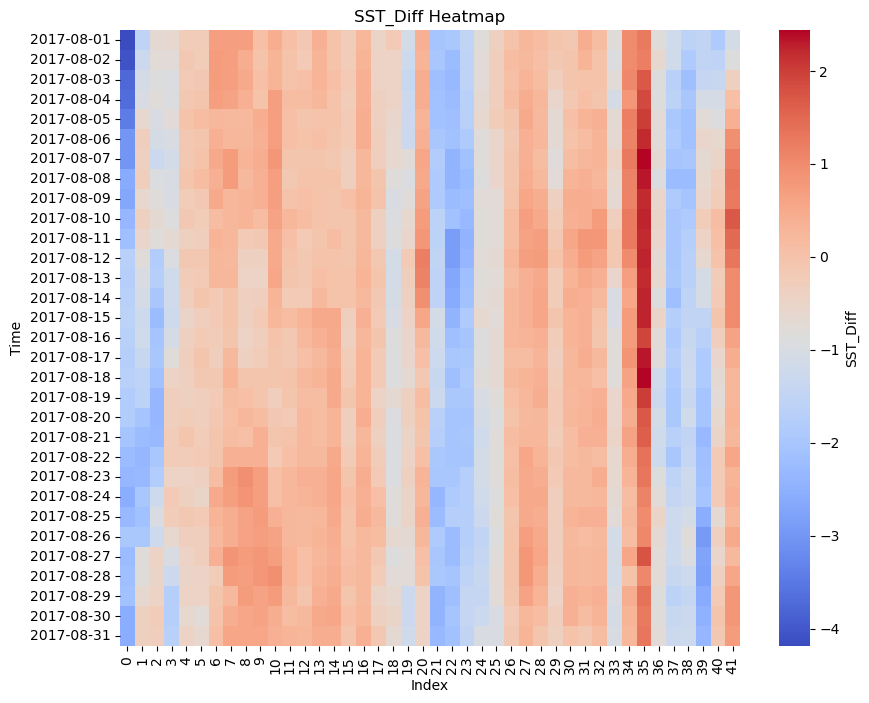

In [16]:
# Convert the 'time' column of df_new_loaded to date format
df_new_loaded['time'] = pd.to_datetime(df_new_loaded['time']).dt.date

# Group the data by 'time' and select the first 42 rows for each group
df_grouped = df_new_loaded.groupby('time').apply(lambda x: x.head(42)).reset_index(drop=True)

# Add a 'group_index' column to track the index within each group
df_grouped['group_index'] = df_grouped.groupby('time').cumcount()

# Pivot the data to create a heatmap-friendly format
df_pivot = df_grouped.pivot(index='time', columns='group_index', values='SST_Diff')

# Create a heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(df_pivot, cmap='coolwarm', cbar_kws={'label': 'SST_Diff'})
plt.title('SST_Diff Heatmap')
plt.ylabel('Time')
plt.xlabel('Index')
plt.show()